# Slime mold dynamical systems model
In this notebook, we will
- Write a (simple 1D) dynamical systems model of slime mold
- Simulate the slime mold model
- Use ChiRho to infer the model parameters from data
- Use ChiRho to infer what would happen if we intervene


In [24]:
# import packages
import pyro
import torch
import numpy as np
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers import LogTrajectory
import matplotlib.pyplot as plt
import seaborn as sns

## Slime mold model
Slime mold agents deposit pheromones, which diffuse and dissipate, and slime mold agents move toward higher pheromone concentrations. 

In [ ]:
# Define the model
class SimpleSlimeDynamics(pyro.nn.PyroModule):

    # About the model
    # B:                the number of spatial bins
    # D:                the density of slime mold agents
    # P:                the density of pheromones
    # dD/dt:            slime mold follows pheromones
    # dP/dt:            pheromones are deposited by slime mold, then diffuse
    # alpha:            pheromone deposition rate
    # beta_diffuse:     pheromone diffusion rate
    # beta_dissipate:   pheromone dissipation rate
    # r:                slime mold following rate

    def __init__(self, B, alpha, beta_diffuse, beta_dissipate, r):
        super().__init__()
        self.B = B
        self.alpha = alpha
        self.beta_diffuse = beta_diffuse
        self.beta_dissipate = beta_dissipate
        self.r = r

    @pyro.nn.pyro_method
    def diff(self, dstate: State[torch.Tensor], state: State[torch.Tensor]) -> None:
        deposition_term = self.alpha * state["D"]
        diffusion_term = self.beta_diffuse * (torch.roll(state["P"], 1) + torch.roll(state["P"], -1) - 2 * state["P"])
        dissipation_term = -self.beta_dissipate * state["P"]

        pheromone_right = torch.relu(torch.roll(state["P"], 1) - state["P"])
        pheromone_left = torch.relu(torch.roll(state["P"], -1) - state["P"])
        slime_flux_right = self.r * pheromone_right * state["D"]
        slime_flux_left = self.r * pheromone_left * state["D"]

        dstate["D"] = torch.roll(slime_flux_right, -1) - slime_flux_right
        dstate["D"] += torch.roll(slime_flux_left, 1) - slime_flux_left
        dstate["P"] = torch.relu(deposition_term + diffusion_term + dissipation_term)


    def forward(self, state: State[torch.Tensor]) -> State[torch.Tensor]:
        dstate = State()
        self.diff(dstate, state)
        return dstate

In [ ]:
# Simulate the model

# Set parameters
B = torch.tensor(15)
alpha = torch.tensor(.75)
beta_diffuse = torch.tensor(.25)
beta_dissipate = torch.tensor(0.01)
r = torch.tensor(1)

# Set up the model
certain_model = SimpleSlimeDynamics(B, alpha, beta_diffuse, beta_dissipate, r)
    
# Set up the initial state
with pyro.plate("bins", B):
    D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
    P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))
initial_state = State(D=D_initial, P=P_initial)

# Set up the trajectory
start_time = torch.tensor(0.0)
end_time = torch.tensor(20.0)
step_size = torch.tensor(1)
trajectory_times = torch.arange(start_time+step_size, end_time, step_size)

# Simulate the model
with LogTrajectory(trajectory_times) as certain_lt:
    final_state = simulate(certain_model, initial_state, start_time, end_time, solver=TorchDiffEq())
certain_trajectory = certain_lt.trajectory

# Plot the results

In [2]:


class BayesianSimpleSlimeSimulator(pyro.nn.PyroModule):
    def __init__(self, B, noise_sigma):
        super().__init__() # inherit stuff from PyroModule
        self.B = B
        self.noise_sigma = noise_sigma

    def forward(self, start_time: torch.Tensor, end_time: torch.Tensor) -> State[torch.Tensor]:
        
        # sample a model from the prior
        alpha = pyro.sample("alpha", pyro.distributions.Uniform(0, 1))
        beta_diffuse = pyro.sample("beta_diffuse", pyro.distributions.Uniform(0, 1))
        beta_dissipate = pyro.sample("beta_dissipate", pyro.distributions.Uniform(0, .1))
        r = pyro.sample("r", pyro.distributions.Uniform(0, 5))
        model = SimpleSlimeDynamics(self.B, alpha, beta_diffuse, beta_dissipate, r)

        # sample the initial conditions from the prior
        with pyro.plate("bins", B):
            D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
            P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))
        initial_state = State(D=D_initial, P=P_initial)

        # simulate the model
        return simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())

class MeasureSlime(pyro.nn.PyroModule):

    # About the model
    # P_observed: the observed density of pheromones
    # D_observed: the observed density of slime mold agents
    # noise_sigma: the standard deviation of the measurement noise

    def __init__(self, noise_sigma):
        super().__init__()
        self.noise_sigma = noise_sigma

    def forward(self, state: State[torch.Tensor]) -> None:
        pyro.sample("observed_D", pyro.distributions.Normal(state["D"], self.noise_sigma).to_event(2)) # to_event(2) means that the distribution is over the last two dimensions, which are space and time
        pyro.sample("observed_P", pyro.distributions.Normal(state["P"], self.noise_sigma).to_event(2))




# Simulate a random trajectory from a random model
uncertain_model = BayesianSimpleSlimeSimulator(B, noise_sigma=0.01)

with LogTrajectory(trajectory_times) as uncertain_lt:
    final_state = uncertain_model(start_time, end_time)

uncertain_trajectory = uncertain_lt.trajectory

# Queries
I have observations from t = 0s and 100s. Given params inferred from this, what would it look like at t=200s if I remove all pheromones at t=150s?

In [3]:
# make synthetic data
noise_sigma = torch.tensor(0.01)
measure_slime = MeasureSlime(noise_sigma)
measured_trajectory = State(**{k:v.squeeze() for k, v in pyro.infer.Predictive(measure_slime, num_samples=1)(certain_trajectory).items()})
measured_trajectory

{'observed_D': tensor([[ 9.0386e-01,  9.8721e-01,  9.9079e-01,  9.0426e-01,  4.7910e-01,
           1.3864e-01,  7.9897e-03,  1.2963e-02, -1.8254e-02, -8.9826e-03,
          -6.7225e-03, -9.7274e-03, -6.4659e-03,  1.0848e-03, -1.5541e-03,
          -5.9965e-03,  4.3078e-04,  1.9810e-03, -1.8500e-02],
         [ 7.5663e-01,  6.6300e-01,  5.1977e-01,  2.9655e-01,  1.2764e-01,
           5.3128e-02,  3.4300e-02,  1.5038e-02,  1.0078e-02, -1.1085e-02,
           6.3941e-03, -2.9754e-03,  7.7243e-03,  9.5296e-03,  1.3118e-02,
           5.2262e-03, -5.6164e-03,  1.2705e-02,  8.9473e-03],
         [ 4.0258e-01,  2.0901e-01,  7.7231e-02,  2.2703e-02, -6.4899e-03,
          -2.0490e-02, -3.5539e-03,  2.8348e-03, -2.3408e-03,  2.2338e-02,
           1.9117e-02,  7.0791e-03, -1.5012e-02, -6.6824e-03, -1.5860e-03,
          -2.1454e-03,  4.1663e-03, -7.7754e-03,  1.5825e-02],
         [ 1.0657e+00,  1.3651e+00,  1.6629e+00,  1.8224e+00,  1.8681e+00,
           1.8793e+00,  1.8732e+00,  1.8893e+00

In [4]:
from chirho.observational.handlers import condition
from chirho.dynamical.handlers import StaticBatchObservation

def conditioned_simulation(start_time, end_time, measurement_times, measured_trajectory):
    obs = condition(data=measured_trajectory)(measure_slime)
    with StaticBatchObservation(measurement_times, observation=obs): # TODO: replace trajectory_times with measurement_times
        uncertain_model(start_time, end_time)

In [12]:
from pyro.infer.autoguide import AutoMultivariateNormal

# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, n_steps=1000, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 1 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

# Run SVI
guide = run_svi_inference(conditioned_simulation, start_time=start_time, end_time=end_time, measurement_times=trajectory_times, measured_trajectory=measured_trajectory)

[iteration 0001] loss: 206137.8281
[iteration 0002] loss: 170198.4219
[iteration 0003] loss: 162740.0469
[iteration 0004] loss: 144449.8438
[iteration 0005] loss: 168299.7344
[iteration 0006] loss: 140065.1406
[iteration 0007] loss: 168843.2969
[iteration 0008] loss: 117326.6875
[iteration 0009] loss: 146298.1250
[iteration 0010] loss: 156735.9219
[iteration 0011] loss: 112154.6406
[iteration 0012] loss: 105110.6719
[iteration 0013] loss: 132408.5312
[iteration 0014] loss: 92057.2656
[iteration 0015] loss: 97687.5312
[iteration 0016] loss: 114583.2422
[iteration 0017] loss: 72427.0469
[iteration 0018] loss: 63263.2422
[iteration 0019] loss: 101328.1016
[iteration 0020] loss: 56329.9453
[iteration 0021] loss: 62826.5898
[iteration 0022] loss: 208389.8594
[iteration 0023] loss: 200434.0625
[iteration 0024] loss: 90741.8047
[iteration 0025] loss: 108847.1875
[iteration 0026] loss: 69009.2734
[iteration 0027] loss: 79718.8281
[iteration 0028] loss: 68798.6484
[iteration 0029] loss: 110384.

In [16]:
from chirho.dynamical.handlers import StaticIntervention, InterruptionEventLoop

def uncertain_model_trajectory(start_time, end_time, measurement_times):
    with LogTrajectory(measurement_times) as lt:
        uncertain_model(start_time, end_time)
    trajectory = lt.trajectory
    # Note: This is a hack to get results of the simulation in the pyro trace, and accessible from the posterior predictive.
    [pyro.deterministic(k, v) for k, v in trajectory.items()]

def intervened_uncertain_model_trajectory(start_time, end_time, measurement_times, intervene_time: torch.Tensor, intervene_state: State[torch.Tensor]):
    with InterruptionEventLoop():
        with StaticIntervention(intervene_time, intervene_state):
            uncertain_model_trajectory(start_time, end_time, measurement_times)

In [7]:
guide()

{'alpha': tensor(0.7847, grad_fn=<ExpandBackward0>),
 'beta_diffuse': tensor(0.3044, grad_fn=<ExpandBackward0>),
 'beta_dissipate': tensor(0.0214, grad_fn=<ExpandBackward0>),
 'r': tensor(0.6277, grad_fn=<ExpandBackward0>),
 'D_initial': tensor([0.8089, 0.6730, 0.4634, 0.7332, 0.5995, 0.3254, 0.1808, 0.4297, 0.7263,
         0.3031, 0.2965, 0.4734, 0.6049, 0.8091, 0.8656],
        grad_fn=<ExpandBackward0>),
 'P_initial': tensor([0.0825, 0.0667, 0.0145, 0.0784, 0.0395, 0.0381, 0.0255, 0.0399, 0.0922,
         0.0299, 0.0120, 0.0364, 0.0252, 0.0551, 0.0889],
        grad_fn=<ExpandBackward0>)}

In [13]:
# Make predictions using the inferred parameters
# Note: guide() is a random function that contains the posterior distribution on inferred parameters. Predictive uses these to sample the trajectory. 
predictions = pyro.infer.Predictive(uncertain_model_trajectory, guide=guide, num_samples=100)(start_time, end_time, trajectory_times)

In [20]:
# intervened predictions
intervene_time = torch.tensor(10.0)
intervene_state = State(P=torch.zeros(B)) # intervene by wiping all pheromones, leave slime mold alone
intervened_predictions = pyro.infer.Predictive(intervened_uncertain_model_trajectory, guide=guide, num_samples=1)(start_time, end_time, trajectory_times, intervene_time, intervene_state)
intervened_trajectory_D = intervened_predictions["D"].squeeze() # predictive returns a collection of predictions
intervened_trajectory_P = intervened_predictions["P"].squeeze()


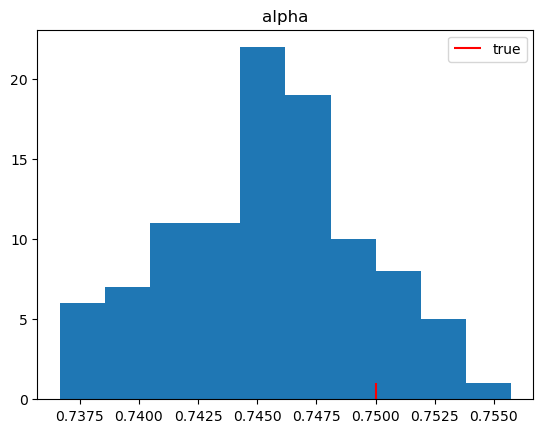

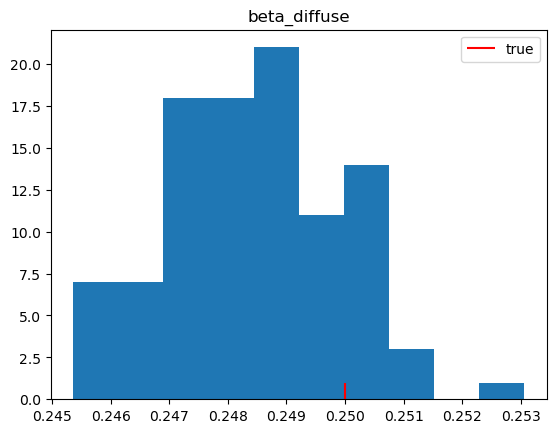

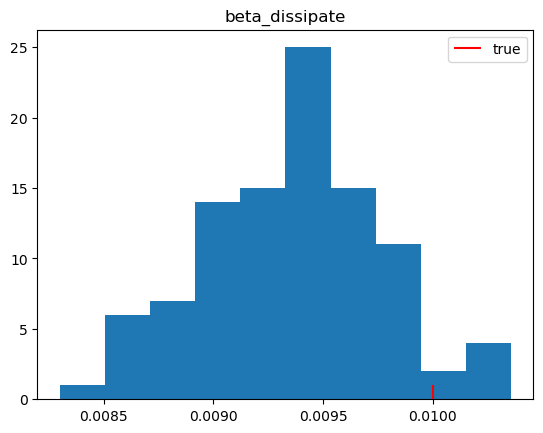

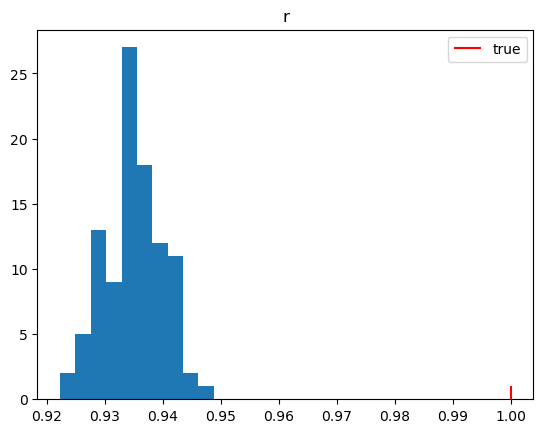

In [14]:
# Check params vs inferred params
# make a dictionary of the true parameters
true_params = {"alpha": alpha, "beta_diffuse": beta_diffuse, "beta_dissipate": beta_dissipate, "r": r}

params_to_show = ["alpha", "beta_diffuse", "beta_dissipate", "r"]
for param in params_to_show:
    # show a histogram of the inferred values
    plt.figure()
    plt.title(param)
    plt.hist(predictions[param].detach().numpy().squeeze())
    plt.vlines(true_params[param], ymin=0,ymax=1, color="red", label="true")
    plt.legend()



In [10]:
# trajectory['D'].sum(dim=0)

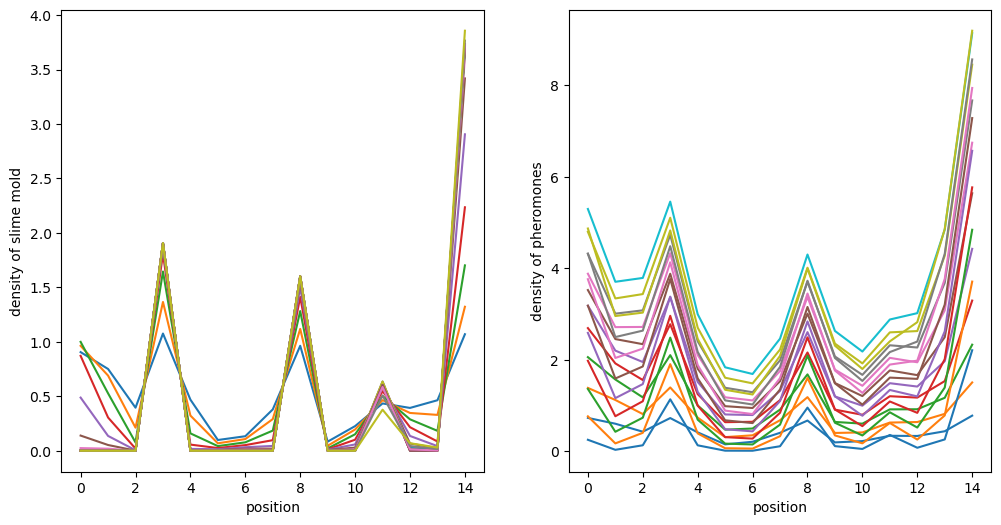

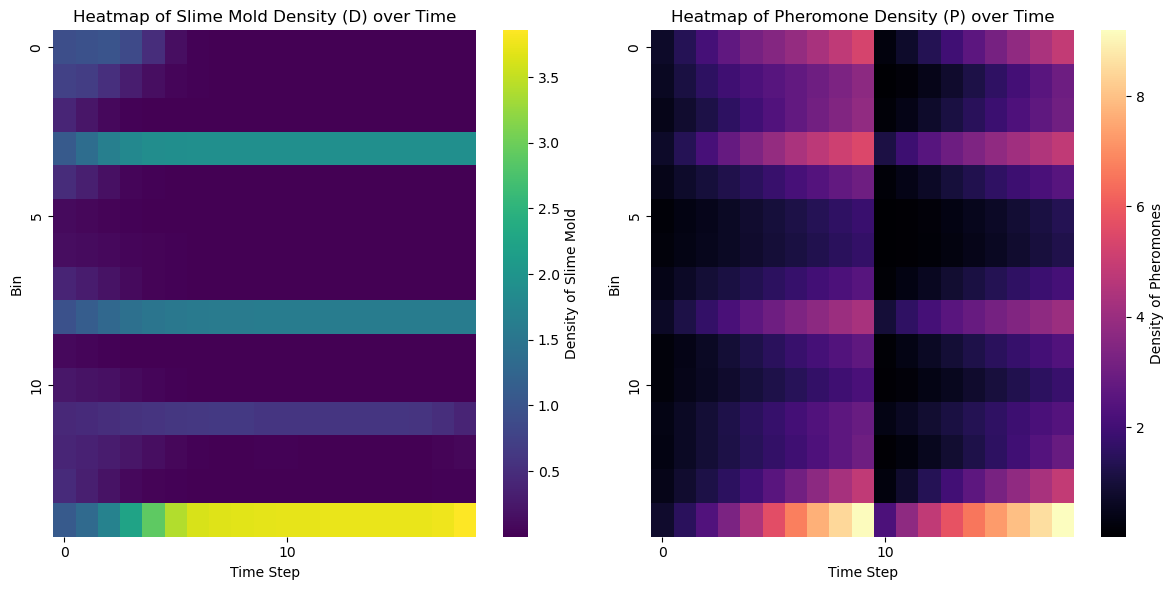

In [21]:

# # Extracting D and P from the trajectory
# D_trajectory = uncertain_trajectory["D"]
# P_trajectory = uncertain_trajectory["P"]
D_trajectory = intervened_trajectory_D
P_trajectory = intervened_trajectory_P
# Time points
time_points = trajectory_times.numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plotting D, as a function of space
plt.subplot(1, 2, 1)
for t in range(len(time_points)):
    plt.plot(D_trajectory[:,t], label="t={}".format(time_points[t]))
plt.xlabel('position')
plt.ylabel('density of slime mold')

# Plotting P, as a function of space
plt.subplot(1, 2, 2)
for t in range(len(time_points)):
    plt.plot(P_trajectory[:,t], label="t={}".format(time_points[t]))
plt.xlabel('position')
plt.ylabel('density of pheromones')


# Plotting
plt.figure(figsize=(12, 6))

# Heatmap for D
plt.subplot(1, 2, 1)
sns.heatmap(D_trajectory, cmap="viridis", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Slime Mold'})
plt.title('Heatmap of Slime Mold Density (D) over Time')
plt.xlabel('Time Step')
plt.ylabel('Bin')

# Heatmap for P
plt.subplot(1, 2, 2)
sns.heatmap(P_trajectory, cmap="magma", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Pheromones'})
plt.title('Heatmap of Pheromone Density (P) over Time')
plt.xlabel('Time Step')
plt.ylabel('Bin')

plt.tight_layout()
plt.show()

